### Base Learner 7b  - Proof of Concept
Prove that we can emulate base-learner-6 (96% acc) by loading a fit10 model and then applying the finetune on top.

In [1]:
from fastai2.vision.all import *
import sys, torch
sys.path.append('..')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# %load_ext autoreload
# %autoreload 2

from modules.expbuilder import default_params, run_exp, rm_test_recorder

train_path = Path('../../../rf-chess-data/cropped_v1/')
train_clean_path = Path('../../../rf-chess-data/cropped_v1.1/')

test_path_all = Path('../../../other-chess-data/regulation-test-2-all/')
test_path_easy = Path('../../../other-chess-data/regulation-test-2-easy/')

In [2]:
learn = load_learner('../models/base-learner7-fit10.pkl')

In [3]:
learn.path

Path('../models')

In [4]:
learn.path = Path('../../../rf-chess-data/cropped_v1.1')

In [5]:
my_params = {'_train_seed':0, '_custom_crop': 'my-top-crop', 
             '_model_arch': resnet50,
            '_train_path':train_clean_path,
            '_learn_norm': False,
            }
default_params.update(my_params)

set_seed(42)
train_dl, learn_fresh = run_exp(default_params, 'dummy', b_ret=True,)

In [6]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,TestSetRecorder]

In [7]:
learn.cbs.pop(3)

TestSetRecorder

In [8]:
learn.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [9]:
learn.dls = learn_fresh.dls

### Assess Loaded Model

              precision    recall  f1-score   support

black-bishop       0.85      0.79      0.81        14
  black-king       0.83      0.91      0.87        11
black-knight       0.80      1.00      0.89        12
  black-pawn       0.84      1.00      0.91        16
 black-queen       1.00      0.31      0.47        13
  black-rook       0.71      1.00      0.83        12
white-bishop       0.59      0.83      0.69        12
  white-king       0.73      0.79      0.76        14
white-knight       0.88      0.93      0.90        15
  white-pawn       0.88      0.93      0.90        15
 white-queen       1.00      0.21      0.35        14
  white-rook       0.80      0.86      0.83        14

    accuracy                           0.80       162
   macro avg       0.82      0.80      0.77       162
weighted avg       0.83      0.80      0.77       162



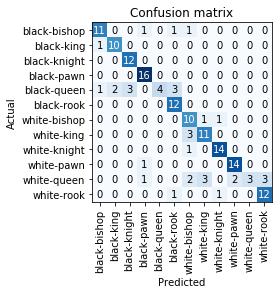

In [10]:
easy_test_dl = learn.dls.test_dl(get_image_files(test_path_easy), 
                                 with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, 
                                                  dl = easy_test_dl)

interp.print_classification_report()

interp.plot_confusion_matrix()

### Continuing Fitting

In [11]:
from modules.learnutils import TestSetRecorder

In [12]:
learn.add_cb(TestSetRecorder())

In [13]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,TestSetRecorder]

In [14]:
set_seed(42)
with learn.no_logging(): learn.fine_tune(20)

In [15]:
pd.DataFrame(learn.cbs[3].values)

,0,1,2,3
0,0.967428,0.732456,0.964912,0.780702
1,0.807136,0.736842,0.969298,0.780702
2,0.796439,0.767544,0.956140,0.815789
3,0.742108,0.785088,0.973684,0.820175
4,0.824949,0.741228,0.956140,0.807018
5,1.001205,0.741228,0.986842,0.776316
6,0.725388,0.798246,0.969298,0.842105
7,0.640379,0.820175,0.982456,0.842105
8,0.725513,0.811404,0.973684,0.846491
9,0.860195,0.793860,0.991228,0.807018


##### Don't forget to pop-off the Test Recorder before doing interp

In [16]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,TestSetRecorder]

In [17]:
learn.cbs.pop(3)

TestSetRecorder

              precision    recall  f1-score   support

black-bishop       1.00      0.93      0.96        14
  black-king       0.90      0.82      0.86        11
black-knight       1.00      1.00      1.00        12
  black-pawn       1.00      1.00      1.00        16
 black-queen       0.80      0.62      0.70        13
  black-rook       0.71      1.00      0.83        12
white-bishop       0.80      1.00      0.89        12
  white-king       1.00      0.79      0.88        14
white-knight       1.00      1.00      1.00        15
  white-pawn       1.00      1.00      1.00        15
 white-queen       0.89      0.57      0.70        14
  white-rook       0.74      1.00      0.85        14

    accuracy                           0.90       162
   macro avg       0.90      0.89      0.89       162
weighted avg       0.91      0.90      0.89       162



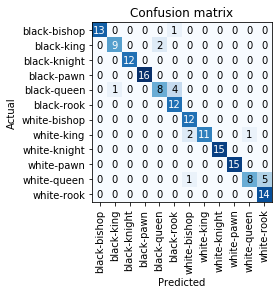

In [18]:
easy_test_dl = learn.dls.test_dl(get_image_files(test_path_easy), 
                                 with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, 
                                                  dl = easy_test_dl)

interp.print_classification_report()

interp.plot_confusion_matrix()

In [19]:
learn.dls.device

device(type='cuda', index=0)

In [21]:
learn.dls[0].after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm